In [1]:
import hu_core_news_lg
import pandas as pd
import spacy
import os
from tqdm import tqdm

In [2]:
try:
    nlp = spacy.load("hu_core_news_lg")
except:
    print("A nagy modell nem található, a közepeset használjuk...")
    nlp = spacy.load("hu_core_news_md")

In [3]:
nlp = hu_core_news_lg.load()

# Loading the data

In [59]:
RAW_CSV = r"../../data/articles.csv"
PROCESSED_CSV = r"../../data/preprocessed_articles.csv"

In [60]:
csv_file = r"../../data/propaganda_articles.csv"

df = pd.read_csv(csv_file, encoding="utf-8-sig")

In [61]:
df.sample()

,url,title,text,label
848,https://index.hu/belfold/2025/12/20/karacsony-...,„A kormány bliccel” – Karácsony Gergelytől les...,"Karácsony Gergely szombaton közölte, hogy a ko...",1


In [62]:
df.label.value_counts()

label
0    756
1    596
Name: count, dtype: int64

# Preprocessing

In [63]:
def spacy_preprocess_pipe(texts, batch_size=50):
    """
    Gyorsabb verzió nlp.pipe használatával és tqdm folyamatjelzővel.
    """
    cleaned_texts = []
    
    # Itt a lényeg: a tqdm-be csomagoljuk az nlp.pipe-ot.
    # A 'total=len(texts)' fontos, hogy tudja, mennyi a 100%.
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, disable=["ner", "parser"]), 
                    total=len(texts), 
                    desc="Szöveg előkészítése"):
        
        tokens = []
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            if token.like_num:
                tokens.append("NUM")
            else:
                tokens.append(token.lemma_)
        
        cleaned_texts.append(" ".join(tokens))
    
    return cleaned_texts

In [64]:
def get_training_data():
    # 1. Betöltjük a nyers adatokat
    if not os.path.exists(RAW_CSV):
        raise FileNotFoundError(f"Nincs meg a forrásfájl: {RAW_CSV}")
        
    df_raw = pd.read_csv(RAW_CSV, encoding="utf-8-sig")
    df_raw = df_raw.dropna(subset=['title', 'text', 'url'])
    
    # 2. Megnézzük, van-e már mentett fájl
    if os.path.exists(PROCESSED_CSV):
        df_processed = pd.read_csv(PROCESSED_CSV, encoding="utf-8-sig")
        processed_urls = set(df_processed['url'])
        print(f"Betöltve {len(df_processed)} már feldolgozott cikk.")
    else:
        df_processed = pd.DataFrame(columns=['url', 'cleaned_text', 'label'])
        processed_urls = set()
        print("Még nincs feldolgozott fájl.")

    # 3. Kiszűrjük az újakat
    df_new = df_raw[~df_raw['url'].isin(processed_urls)].copy()

    if df_new.empty:
        print("Nincs új feldolgozandó cikk! A cache-ből dolgozunk.")
    else:
        print(f"Feldolgozás alatt: {len(df_new)} új cikk...")
        
        df_new['full_text'] = df_new['title'] + ": " + df_new['text']
        
        # --- ITT HÍVJUK MEG A TQDM-ES FÜGGVÉNYT ---
        df_new['cleaned_text'] = spacy_preprocess_pipe(df_new['full_text'].tolist())
        
        # 4. Mentés
        df_to_save = df_new[['url', 'cleaned_text', 'label']]
        header_needed = not os.path.exists(PROCESSED_CSV)
        
        df_to_save.to_csv(PROCESSED_CSV, mode='a', index=False, header=header_needed, encoding='utf-8-sig')
        
        # Összefűzés a memóriában
        df_processed = pd.concat([df_processed, df_to_save], ignore_index=True)
        print("Új adatok elmentve.")

    return df_processed['cleaned_text'], df_processed['label']

In [65]:
def spacy_preprocess_one(text):
    """
    Egyetlen string preprocesszálása (inferencia/jóslás idejére).
    Ugyanazt a logikát követi, mint a spacy_preprocess_pipe.
    """
    # 1. Itt simán hívjuk az nlp-t, nem pipe-on keresztül
    # A disable itt is gyorsít, ha csak lemma kell
    doc = nlp(text, disable=["ner", "parser"])
    
    clean_tokens = []
    for token in doc:
        # Ugyanaz a szűrés
        if token.is_stop or token.is_punct:
            continue
        if token.like_num:
            clean_tokens.append("NUM")
        else:
            clean_tokens.append(token.lemma_)
    
    return " ".join(clean_tokens)

In [66]:
x, y = get_training_data()
y = y.astype(int)
x.sample()

Betöltve 1317 már feldolgozott cikk.
Nincs új feldolgozandó cikk! A cache-ből dolgozunk.


759    négyes karambol M0-son két sáv lezár M0-s autó...
Name: cleaned_text, dtype: object

In [67]:
y.value_counts()

label
0    723
1    594
Name: count, dtype: int64

# CountVectorizer

In [68]:
hu_stop_words = [
    "2010", "2020", "a", "abban", "ad", "adatvédelmi nyilatkozat", "ahhoz", "ahogy", 
    "ahol", "ahogy", "aki", "akik", "akit", "akár", "akkor", "alá", "alatt", "által", 
    "általában", "amely", "amelyek", "amelyekben", "amelyeket", "amelyet", "amelynek", 
    "ami", "amíg", "amikor", "amit", "amolyan", "amúgy", "annak", "arra", "arról", 
    "át", "az", "azért", "azok", "azoknak", "azon", "azonban", "azt", "aztán", 
    "azután", "azzal", "ászf", "bár", "be", "bele", "belül", "benne", "cikk", 
    "cikkek", "cikkeket", "com", "copyright", "csak", "de", "e", "ebben", "eddig", 
    "egész", "egy", "egyéb", "egyes", "egyetlen", "egyik", "egyre", "ehhez", "ekkor", 
    "el", "elég", "ellen", "elő", "először", "előtt", "első", "ember", "emilyen", 
    "én", "ennek", "éppen", "erre", "es", "esetleg", "és", "evvel", "ez", "ezek", 
    "ezen", "ezért", "ezt", "ezzel", "fel", "feladva", "felé", "felett", "fel", 
    "főleg", "ha", "hanem", "hát", "hello", "helló", "helyett", "hirtelen", 
    "hiszen", "hogy", "hogyan", "hol", "hozzászólás", "hozzászólások", "http", 
    "ide", "igen", "így", "igy", "ill", "ill.", "illetve", "ilyen", "ilyenkor", 
    "impresszum", "is", "ismét", "ison", "itt", "jó", "jobban", "jog fenntartva", 
    "jogi nyilatkozat", "jól", "kategória", "kell", "kellett", "keressünk", 
    "keresztül", "ki", "kis", "kívül", "komment", "köszönöm", "köszönjük", "köszi", 
    "közepette", "között", "közül", "külön", "le", "legalább", "legyen", "lehet", 
    "lehetett", "lenne", "lenni", "lesz", "lett", "maga", "magam", "magatokat", 
    "magát", "magunk", "magunkat", "magunkkal", "magunkra", "majd", "már", "más", 
    "másik", "meg", "még", "mellett", "mely", "melyek", "mert", "mi", "miért", 
    "míg", "mikor", "milyen", "mind", "minden", "mindenki", "mindenkinek", 
    "mindenkit", "mindent", "mindig", "mindneki", "mint", "mintha", "mit", 
    "mivel", "most", "nagy", "nagyobb", "nagyon", "ne", "néha", "néhány", 
    "nekem", "neki", "nélkül", "nem", "nincs", "ő", "oda", "ők", "õk", "őket", 
    "oka", "olyan", "ön", "os", "össze", "ott", "pedig", "persze", "pici", 
    "picivel", "pont", "rá", "rám", "rajtam", "ripost", "rólam", "rólunk", "rss", 
    "s", "saját", "sajnos", "sem", "semmi", "soha", "sok", "sokat", "sokkal", 
    "száma", "számára", "szemben", "szerint", "szerintem", "szeretettel", 
    "szerző", "szét", "szia", "sziasztok", "szinte", "szó", "talán", "te", 
    "tehát", "teljes", "ti", "több", "tőle", "tőlem", "tőletek", "tőlük", 
    "tőlünk", "tovább", "továbbá", "üdv", "úgy", "ugyanis", "új", "újabb", 
    "újra", "után", "utána", "utolsó", "vagy", "vagyis", "vagyok", "valaki", 
    "valami", "valamint", "valamit", "valaminek", "valamiért", "való", "van", 
    "vannak", "vele", "velem", "veletek", "velük", "vissza", "viszont", "volna", 
    "volt", "voltak", "voltam", "voltunk", "www"
]

In [69]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [70]:
vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1, max_df=0.9, max_features=2000, stop_words=hu_stop_words)
x_counts = vectorizer.fit_transform(x)

C:\Users\Levi\Documents\PyCharm Projects\propaganda\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['adatvédelmi', 'fenntartva', 'jog', 'jogi', 'nyilatkozat'] not in stop_words.
  warnings.warn(


# Tfidf

In [71]:
tfidf = TfidfTransformer(sublinear_tf=True)
x_tfidf = tfidf.fit_transform(x_counts)

In [72]:
x_tfidf.shape

(1317, 2000)

In [73]:
# 1. Kinyerjük a szavakat (feature neveket)
feature_names = vectorizer.get_feature_names_out()

# 2. Összegezzük az előfordulásokat oszloponként (axis=0) a teljes adathalmazra
# Az x_counts egy ritka mátrix (sparse matrix), ezért konvertálni kell, vagy a sum-ot használni
sum_words = x_counts.sum(axis=0) 

# 3. Készítünk egy DataFrame-et a szavakból és a darabszámokból
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
# Rendezés gyakoriság szerint csökkenő sorrendbe
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

df_freq = pd.DataFrame(words_freq, columns=['Szó', 'Gyakoriság'])

print("Leggyakoribb 10 kifejezés:")
display(df_freq.head(15))

Leggyakoribb 10 kifejezés:


,Szó,Gyakoriság
0,num,7490
1,magyar,3343
2,év,1941
3,tud,1649
4,tisza,1616
5,orbán,1359
6,párt,1159
7,tesz,1141
8,péter,1102
9,ír,1035


In [74]:
# Átlagos TF-IDF súly kiszámítása
mean_tfidf = x_tfidf.mean(axis=0)
tfidf_scores = [(feature_names[i], mean_tfidf[0, i]) for i in range(len(feature_names))]
tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

df_tfidf_top = pd.DataFrame(tfidf_scores, columns=['Szó', 'Átlag_TFIDF'])
print("\nLegmagasabb TF-IDF értékű szavak:")
print(df_tfidf_top.head(10))


Legmagasabb TF-IDF értékű szavak:
      Szó  Átlag_TFIDF
0     num     0.047579
1  magyar     0.036235
2   tisza     0.028088
3      év     0.027322
4   orbán     0.023734
5     tud     0.023701
6   péter     0.023380
7    párt     0.022910
8      ír     0.022855
9    tesz     0.021610


# Train, valid, test

In [75]:
from sklearn.model_selection import train_test_split

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_tfidf, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)
print(f"Tanító+Validáló készlet mérete: {x_train_full.shape[0]}")
print(f"Végső tesztkészlet mérete: {x_test.shape[0]}") 

Tanító+Validáló készlet mérete: 1119
Végső tesztkészlet mérete: 198


In [76]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [77]:
fold = 1
for train_index, val_index in skf.split(x_train_full, y_train_full):
    # Itt jön létre a tényleges szétválasztás a listákra/tömbökre
    x_train, x_valid = x_train_full[train_index], x_train_full[val_index]
    y_train, y_valid = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    
    print(f"\n--- {fold}. FOLD ---")
    print(f"Tanító (X_train): {x_train.shape[0]} db")
    print(f"Validációs (X_valid): {x_valid.shape[0]} db")
    print(f"Teszt (X_test): {x_test.shape[0]} db (fix)")
    
    # Itt már használhatod a változókat: X_train, y_train, X_valid, y_valid, X_test, y_test
    fold += 1


--- 1. FOLD ---
Tanító (X_train): 895 db
Validációs (X_valid): 224 db
Teszt (X_test): 198 db (fix)

--- 2. FOLD ---
Tanító (X_train): 895 db
Validációs (X_valid): 224 db
Teszt (X_test): 198 db (fix)

--- 3. FOLD ---
Tanító (X_train): 895 db
Validációs (X_valid): 224 db
Teszt (X_test): 198 db (fix)

--- 4. FOLD ---
Tanító (X_train): 895 db
Validációs (X_valid): 224 db
Teszt (X_test): 198 db (fix)

--- 5. FOLD ---
Tanító (X_train): 896 db
Validációs (X_valid): 223 db
Teszt (X_test): 198 db (fix)


# LinearSVC

In [78]:
from sklearn.svm import LinearSVC, SVC

svc = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=5000
)
svc.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [79]:
from sklearn.metrics._classification import classification_report
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       109
           1       0.84      0.80      0.82        89

    accuracy                           0.84       198
   macro avg       0.84      0.83      0.84       198
weighted avg       0.84      0.84      0.84       198



# Finetuning

In [80]:
from sklearn.metrics import f1_score
# 1. Listák inicializálása (ez hiányzott!)
valid_f1 = []
train_f1 = []
C_values = []

# 2. Ciklus
# A range(-7, 5) jó: 10^-7 -től 10^4 -ig megy
for l in range(-7, 5):
    C = 10**l
    C_values.append(C)
    
    # LinearSVC létrehozása
    # Tipp: dual="auto" javasolt újabb sklearn verzióknál, ha n_samples > n_features
    lin = LinearSVC(
        random_state=42,
        max_iter=20000, # Érdemes növelni, ha "ConvergenceWarning"-ot kapsz
        class_weight="balanced",
        C=C,
        dual="auto" # Ha sklearn > 1.3 verziód van, ez segít a gyorsulásban és konvergenciában
    )
    
    lin.fit(x_train, y_train)
    
    # Predikció
    valid_pred = lin.predict(x_valid)
    train_pred = lin.predict(x_train)
    
    # Score mentése
    valid_f1.append(f1_score(y_valid, valid_pred, pos_label=1))
    train_f1.append(f1_score(y_train, train_pred, pos_label=1))

    print(f"C={C:.1e} kész.") # Opcionális: látod hol tart

C=1.0e-07 kész.
C=1.0e-06 kész.
C=1.0e-05 kész.
C=1.0e-04 kész.
C=1.0e-03 kész.
C=1.0e-02 kész.
C=1.0e-01 kész.
C=1.0e+00 kész.
C=1.0e+01 kész.
C=1.0e+02 kész.
C=1.0e+03 kész.
C=1.0e+04 kész.


C:\Users\Levi\Documents\PyCharm Projects\propaganda\.venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


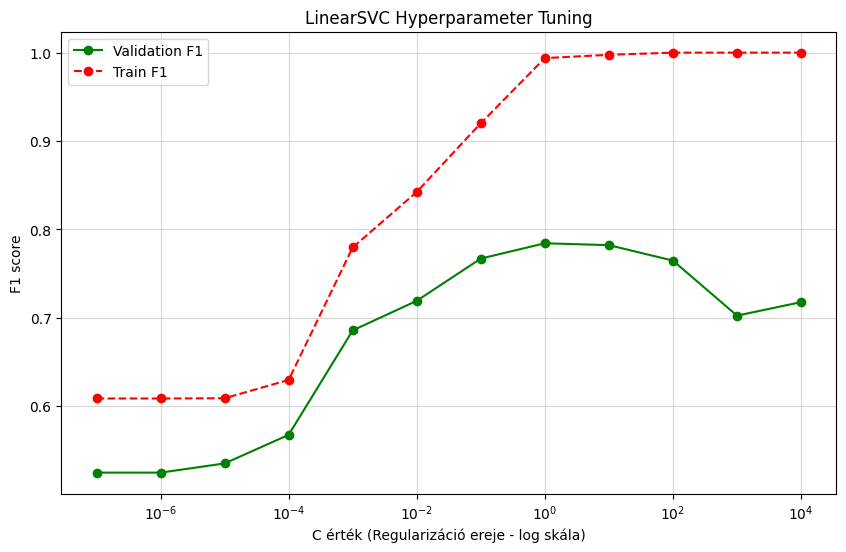

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(C_values, valid_f1, label="Validation F1", marker="o", color="green")
plt.plot(C_values, train_f1, label="Train F1", marker="o", color="red", linestyle="--")

plt.xscale("log")  # EZ TÖKÉLETES ÍGY!
plt.xlabel("C érték (Regularizáció ereje - log skála)")
plt.ylabel("F1 score")
plt.title("LinearSVC Hyperparameter Tuning")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

In [82]:
svc = LinearSVC(random_state=0,
                           max_iter=20000,
                           class_weight="balanced",
                           C=10**(0),
                           dual="auto")
svc.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo 

In [83]:
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       109
           1       0.84      0.80      0.82        89

    accuracy                           0.84       198
   macro avg       0.84      0.83      0.84       198
weighted avg       0.84      0.84      0.84       198



In [84]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(svc, method='sigmoid', cv=5)
calibrated_svc.fit(x_train, y_train)

# 2. Lekérjük a valószínűségeket a tesztkészletre
probs = calibrated_svc.predict_proba(x_test)
preds = calibrated_svc.predict(x_test)

# 3. Nézzünk meg pár példát (Pl. az első 5 cikk)
for i in range(5):
    confidence = probs[i][preds[i]] * 100  # A megjósolt osztály valószínűsége %-ban
    label = "Propaganda" if preds[i] == 1 else "Nem propaganda"
    print(f"{i+1}. cikk jóslata: {label} ({confidence:.2f}%-os biztonsággal)")

1. cikk jóslata: Nem propaganda (98.21%-os biztonsággal)
2. cikk jóslata: Propaganda (57.68%-os biztonsággal)
3. cikk jóslata: Propaganda (58.72%-os biztonsággal)
4. cikk jóslata: Nem propaganda (62.10%-os biztonsággal)
5. cikk jóslata: Nem propaganda (94.76%-os biztonsággal)


In [85]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       109
           1       0.86      0.79      0.82        89

    accuracy                           0.85       198
   macro avg       0.85      0.84      0.85       198
weighted avg       0.85      0.85      0.85       198



# GradientBoostingClassifier

In [86]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    min_samples_leaf=5,
    random_state=42
)

# Ensemble

In [87]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[('svc', calibrated_svc), ('gb', gb_model)],
    voting='hard' # A valószínűségek átlagát nézi
)
ensemble_model.fit(x_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('svc', ...), ('gb', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1


In [88]:
from sklearn.metrics import accuracy_score

y_pred = ensemble_model.predict(x_test)

# Részletes statisztika
print("Pontosság:", accuracy_score(y_test, y_pred))
print("\nOsztályozási jelentés:\n", classification_report(y_test, y_pred))

Pontosság: 0.7929292929292929

Osztályozási jelentés:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83       109
           1       0.86      0.64      0.74        89

    accuracy                           0.79       198
   macro avg       0.81      0.78      0.78       198
weighted avg       0.81      0.79      0.79       198



# Grid Search

In [89]:
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import GradientBoostingClassifier
from scipy.sparse import vstack as sparse_vstack

# 1. Ritka mátrixok (X) összefűzése speciális függvénnyel
X_combined = sparse_vstack([x_train, x_valid])

# 2. Címkék (y) összefűzése (ezek sima tömbök, marad a concatenate)
y_combined = np.concatenate([y_train, y_valid])

# 3. Ellenőrzés (opcionális, de jó, ha látod)
print(f"X_combined alakja: {X_combined.shape}") # (1219, features) kell legyen
print(f"y_combined hossza: {len(y_combined)}") # 1219 kell legyen

# 4. A split ugyanaz marad: -1 a tanító, 0 a validációs
test_fold = np.zeros(X_combined.shape[0])
test_fold[:x_train.shape[0]] = -1
test_fold[x_train.shape[0]:] = 0

ps = PredefinedSplit(test_fold)

X_combined alakja: (1119, 2000)
y_combined hossza: 1119


In [90]:
from sklearn.model_selection import RandomizedSearchCV

# Definíció
gb_base = GradientBoostingClassifier(random_state=42)
ensemble_grid = VotingClassifier(
    estimators=[('svc', calibrated_svc), ('gb', gb_model)]
)

param_grid = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3, 4, 5],
    'gb__subsample': [0.7, 0.8, 1.0],
    'gb__min_samples_leaf': [3, 5, 7],
    
    'weights': [
        [1, 1], # Egyenlő szavazat
        [2, 1], # SVC súlyosabb (mivel az alapmodellünk erősebb volt)
        [3, 1], # SVC sokkal súlyosabb
        [3, 2]  # Finomabb hangolás az SVC javára
    ]
}

# Grid Search indítása a PredefinedSplit segítségével
random_search = RandomizedSearchCV(
    estimator=ensemble_grid, 
    param_distributions=param_grid, # Ugyanaz a rács, amit megadtál
    n_iter=75,                      # CSAK 50 véletlen kombinációt próbál ki
    cv=ps, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_combined, y_combined)

print(f"Legjobb paraméterek: {random_search.best_params_}")
print(f"Legjobb pontosság a validációs halmazon: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_
y_pred_f = final_model.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_f))

Fitting 1 folds for each of 75 candidates, totalling 75 fits
Legjobb paraméterek: {'weights': [3, 2], 'gb__subsample': 1.0, 'gb__n_estimators': 100, 'gb__min_samples_leaf': 3, 'gb__max_depth': 4, 'gb__learning_rate': 0.1}
Legjobb pontosság a validációs halmazon: 0.8072
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       109
           1       0.84      0.76      0.80        89

    accuracy                           0.83       198
   macro avg       0.83      0.82      0.82       198
weighted avg       0.83      0.83      0.83       198



In [91]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.7,
    min_samples_leaf=3,
    random_state=42
)

In [97]:
# gb = GradientBoostingClassifier(
#     max_depth=4,
#     min_samples_leaf=3,
#     n_estimators=200,
#     random_state=42,
#     subsample=0.7
# )
# svc = LinearSVC(C=1, max_iter=20000, class_weight='balanced', random_state=0)
# gb.fit(x_train, y_train)
# svc.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo 

In [112]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[('svc', calibrated_svc), ('gb', gb_model)],
    voting='soft'
)
ensemble_model.fit(x_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('svc', ...), ('gb', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1


In [113]:
from sklearn.metrics import accuracy_score
y_pred = ensemble_model.predict(x_test)

# Részletes statisztika
print("Pontosság:", accuracy_score(y_test, y_pred))
print("\nOsztályozási jelentés:\n", classification_report(y_test, y_pred))

Pontosság: 0.8232323232323232

Osztályozási jelentés:
               precision    recall  f1-score   support

           0       0.81      0.88      0.85       109
           1       0.84      0.75      0.79        89

    accuracy                           0.82       198
   macro avg       0.83      0.82      0.82       198
weighted avg       0.82      0.82      0.82       198



# Saving the modell

In [94]:
from joblib import dump, load
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('count', vectorizer),
    ('tfidf', tfidf),
    ('clf', ensemble_model)
])
pipeline.fit(x, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('count', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [95]:
dump(pipeline, '../../models/ensemble_pipeline.joblib')